# Acompanhamento de Fundos de Investimento Imobiliários (FIIs)

O presente projeto busca acompanhar alguns grupos de FIIs semelhantes em seu valor de mercado em uma série temporal junto a variáveis macro econômicas. 

Mais especificamente, elencamos como foco de comparação o fundo TGAR11.SA e os seguinte fundos na condição de fundos semelhantes em sua condição de mercado para fator de comparação: CDII11.SA, KNHY11.SA, KNCR11.SA, JURO11.SA, VGIR11.SA, IFRA11.SA, CACR11.SA, KDIF11.SA, TVRI11.SA e XPML11.SA

Em termos de variáveis macroeconômicas, consideramos 3 frentes: 
  
  A inflação mais ampla frente ao consumidor, para buscar uma vasriável correlacionada ao poder e disposição de compra de papeis de investimento - IPCA; 

  A inflação para a constrtução como possível impactador das margens que regem os fundos - INCC;

  E, por fim a índice geral de juros do mercado, a taxa Selic.


Questões que norteiam esta investigação partem de concepções populares, como a tendência de oscilação positiva em fundos frente a determinadas situações macroeconômicas, como quedas significativas na infação da construção civil ou da taxa selic e o inverso na alta dessas mesmas variáveis. 

Dessa forma, por interesse pessoal investigo um fundo (TGAR11.SA) e busco fundos de movimentação semelhante em um mesmo período de fortes oscilações para iniciar uma visão crítica dessas crenças. 


### Instalação de bibliotecas e preparação do notebook para trabalho

In [0]:
pip install pandas yfinance


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
dbutils.library.restartPython()

In [0]:
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from datetime import datetime


---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-1443902345204260>:3
      1 import yfinance as yf
      2 import pandas as pd
----> 3 import ace_tools as tools
      4 from pyspark.sql import SparkSession
      5 from pyspark.sql.functions import col, to_date

File /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171, in _create_import_patch.<locals>.import_patch(name, globals, locals, fromlist, level)
    166 thread_local._nest_level += 1
    168 try:
    169     # Import the desired module. If you’re seeing this while debugging a failed import,
    170     # look at preceding stack frames for relevant error information.
--> 171     original_result = python_builtin_import(name, globals, locals, fromlist, level)
    173     is_root_import = thread_local._nest_level == 1
    174     # `level` represents the number of leading dots in a re

## Extraindo os dados de FIIs

Para extrair os dados históricos dos fundos selecionados, buscamos a biblioteca yfinance, para carregar os registros de variação de preço entre abertura e fechamento. Os dados seram carregados dentro do período de 2020 até a data mais recente

Com excessão de um pequeno ajuste no rformato de dados, o dataframe é convertido para spark e carregado enquanto "fiis_raw" no AWS S3

Uma vez no storage, os dados são carregados também para o databricks

In [0]:

# Definindo Variáveis
fiis = ['TGAR11.SA', 'CDII11.SA', 'KNHY11.SA', 'KNCR11.SA', 'JURO11.SA', 'VGIR11.SA', 'IFRA11.SA', 'CACR11.SA', 'KDIF11.SA', 'TVRI11.SA', 'XPML11.SA']
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

fii_data = {}

# Coletando dados históricos de FIIs
for fii in fiis:
    ticker = yf.Ticker(fii)
    data = ticker.history(start=start_date, end=end_date)
    if not data.empty:
        fii_data[fii] = data['Close']

# Convertendo os dados para DataFrame do Pandas
df = pd.DataFrame(fii_data).reset_index()

# Sessão Spark
spark = SparkSession.builder \
    .appName("FinanceDataToS3") \
    .config("spark.hadoop.fs.s3a.access.key", "YOUR_AWS_ACCESS_KEY_ID") \
    .config("spark.hadoop.fs.s3a.secret.key", "YOUR_AWS_SECRET_ACCESS_KEY") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
    .getOrCreate()

# Converter para DataFrame Spark
df_spark = spark.createDataFrame(df)

# Definir paths no S3
s3_base_path = "s3a://mvp-data-engeneering/"
raw_path = f"{s3_base_path}raw/fiis_raw"

# Salvar dados "raw" em formato Parquet no S3
df_spark.write.format("parquet").mode("overwrite").save(raw_path)

# Registrando a tabela "fiis_raw" no catálogo do Databricks a partir do S3
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS fiis_raw
    USING PARQUET
    LOCATION '{raw_path}'
""")

# Lendo os dados "raw" do S3
df_spark = spark.read.format("parquet").load(raw_path)

# Criando a coluna de data formatada apenas como data
df_spark_clean = df_spark.withColumn("Date", to_date(col("Date")))

# Definir o path para a tabela "flat" no S3
final_s3_path = f"{s3_base_path}final_flat"

# Salvar o DataFrame "flat" em formato Delta no S3 com overwriteSchema
df_spark_clean.write.format("delta").mode("overwrite").save(final_s3_path)

# Registrando a tabela "fiis_clean" no catálogo do Databricks diretamente do DataFrame transformado
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS fiis_clean
    USING DELTA
    LOCATION '{final_s3_path}'
""")

# Exibindo o DataFrame final
df_spark_clean.show()


+----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+---------+---------+-----------------+------------------+
|      Date|         TGAR11.SA|         CDII11.SA|        KNHY11.SA|        KNCR11.SA|         JURO11.SA|        VGIR11.SA|         IFRA11.SA|CACR11.SA|KDIF11.SA|        TVRI11.SA|         XPML11.SA|
+----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+---------+---------+-----------------+------------------+
|2023-12-19|    109.4345703125| 98.61164855957031|95.09867095947266|95.65522003173828| 100.3310775756836|8.992963790893555|100.48789978027344|     null|     null|89.96345520019531|106.25736236572266|
|2023-12-20|   109.44384765625| 98.34335327148438|94.80177307128906|95.38402557373047|     101.060546875|9.030396461486816|100.23612976074219|     null|     null| 90.2187728881836|107.54033660888672|


### Transformação do conjunto de dados de FIIs

Algumas transformações são necessárias para que os dados fiquem prontos para consumo para stakeholders. A título de trazer um horizonte temporal que faça sentido para essas variações frente às variáveis macroeconômicas que buscamos ter para correlação, buscamos aqui realizar um data trunc da data para destar e permitir o group by pelo mês de modo uniforme. Em seguida, acertamos também um cálculo de mediana da variação, para acompanhamento. 

In [0]:
%sql
-- select *
-- from fiis_clean

-- Criação de uma CTE para os dados originais
WITH fund_data AS (
  SELECT
    Date,
    'TGAR11.SA' AS Fundo, `TGAR11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'CDII11.SA' AS Fundo, `CDII11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'KNHY11.SA' AS Fundo, `KNHY11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'KNCR11.SA' AS Fundo, `KNCR11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'JURO11.SA' AS Fundo, `JURO11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'VGIR11.SA' AS Fundo, `VGIR11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'IFRA11.SA' AS Fundo, `IFRA11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'CACR11.SA' AS Fundo, `CACR11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'KDIF11.SA' AS Fundo, `KDIF11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'TVRI11.SA' AS Fundo, `TVRI11.SA` AS Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'XPML11.SA' AS Fundo, `XPML11.SA` AS Cotacao
  FROM fiis_clean
),

-- Cálculo da mediana mensal para cada fundo
medianas AS (
  SELECT
    DATE_TRUNC('month', Date) AS mes,
    Fundo,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Cotacao) AS mediana_cotacao
  FROM fund_data
  GROUP BY DATE_TRUNC('month', Date), Fundo
)

-- Consulta principal para juntar os dados originais com as medianas
SELECT
  f.Date,
  f.Fundo,
  f.Cotacao,
  m.mediana_cotacao
FROM fund_data f
LEFT JOIN medianas m
ON DATE_TRUNC('month', f.Date) = m.mes AND f.Fundo = m.Fundo
ORDER BY f.Date, f.Fundo;


Date,Fundo,Cotacao,mediana_cotacao
2020-01-02,CACR11.SA,null,null
2020-01-02,CDII11.SA,null,null
2020-01-02,IFRA11.SA,null,null
2020-01-02,JURO11.SA,null,null
2020-01-02,KDIF11.SA,null,null
2020-01-02,KNCR11.SA,78.39177703857422,78.8687858581543
2020-01-02,KNHY11.SA,87.84247589111328,87.67538452148438
2020-01-02,TGAR11.SA,81.27385711669922,81.56532669067383
2020-01-02,TVRI11.SA,null,null
2020-01-02,VGIR11.SA,7.898726463317871,7.172821044921875


## Extração dos dados de variáveis macroecômicas

Nesse ponto, buscamos a extração da séris históricas dos índices de interesse através da API do BACEN. Por serem bases fundamentais para diversas análises, essas são extraídas em sua inteireza. 

Da mesma forma que anteriormente, realizamos um tratamento simples no campo de data e salvamos cada uma da mesma forma que a tabela anterior, marcadas como raw no S3 e do S3 para o databricks. 

Adicionalmente acrescentamos também um acompanhamento da mediana mensal da selic diária em uma tabela a parte, salva da mesma forma que as anteriores. 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, date_format
import requests
import pandas as pd

# Função para obter dados do Banco Central usando URLs específicas para cada índice
def get_bacen_data(url):
    response = requests.get(url)
    data = response.json()
    
    # Convertendo para DataFrame
    df = pd.DataFrame(data)
    
    # Ajustando a estrutura do DataFrame conforme a inspeção
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
    df['valor'] = df['valor'].astype(float)
    
    return df

# Inicializando Spark com configuração AWS
spark = SparkSession.builder \
    .appName("FIIs") \
    .config("spark.hadoop.fs.s3a.access.key", "YOUR_AWS_ACCESS_KEY_ID") \
    .config("spark.hadoop.fs.s3a.secret.key", "YOUR_AWS_SECRET_ACCESS_KEY") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
    .config("spark.databricks.delta.schema.autoMerge.enabled", "true") \
    .getOrCreate()

# URLs específicas para cada índice sem parâmetros de tempo
ipca_url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json"
selic_url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json"
incc_url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.7454/dados?formato=json"

# Obtendo os dados
ipca_df = get_bacen_data(ipca_url)  # IPCA
selic_df = get_bacen_data(selic_url)  # SELIC diária
incc_df = get_bacen_data(incc_url)  # INCC

# Filtrando para remover datas futuras
today = pd.Timestamp('today').normalize()
ipca_df = ipca_df[ipca_df['data'] < today]
selic_df = selic_df[selic_df['data'] < today]
incc_df = incc_df[incc_df['data'] < today]

# Calculando a mediana mensal da SELIC
selic_df['mes_ano'] = selic_df['data'].dt.to_period('M').dt.to_timestamp('M')
selic_mediana_mensal_df = selic_df.groupby('mes_ano').agg({'valor': 'median'}).reset_index()
selic_mediana_mensal_df['data'] = selic_mediana_mensal_df['mes_ano']
selic_mediana_mensal_df = selic_mediana_mensal_df[['data', 'valor']].rename(columns={'valor': 'mediana_selic'})

# Convertendo Pandas DataFrames para Spark DataFrames
ipca_spark_df = spark.createDataFrame(ipca_df).withColumn("data", to_date(col("data")))
selic_spark_df = spark.createDataFrame(selic_df).withColumn("data", to_date(col("data")))
selic_mediana_spark_df = spark.createDataFrame(selic_mediana_mensal_df).withColumn("data", to_date(col("data")))
incc_spark_df = spark.createDataFrame(incc_df).withColumn("data", to_date(col("data")))

# Renomeando as colunas para evitar conflitos ao unir os DataFrames
ipca_spark_df = ipca_spark_df.withColumnRenamed("valor", "valor_ipca")
selic_spark_df = selic_spark_df.withColumnRenamed("valor", "valor_selic")
incc_spark_df = incc_spark_df.withColumnRenamed("valor", "valor_incc")

# Salvando os DataFrames individuais com mergeSchema
ipca_s3_path = "s3a://mvp-data-engeneering/ipca"
selic_s3_path = "s3a://mvp-data-engeneering/selic"
incc_s3_path = "s3a://mvp-data-engeneering/incc"
selic_mediana_s3_path = "s3a://mvp-data-engeneering/selic_mediana"

ipca_spark_df.write.format("delta").option("mergeSchema", "true").mode("overwrite").save(ipca_s3_path)
selic_spark_df.write.format("delta").option("mergeSchema", "true").mode("overwrite").save(selic_s3_path)
incc_spark_df.write.format("delta").option("mergeSchema", "true").mode("overwrite").save(incc_s3_path)
selic_mediana_spark_df.write.format("delta").option("mergeSchema", "true").mode("overwrite").save(selic_mediana_s3_path)

# Registrando as tabelas no catálogo do Databricks
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS ipca_raw
    USING DELTA
    LOCATION '{ipca_s3_path}'
""")
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS selic_raw
    USING DELTA
    LOCATION '{selic_s3_path}'
""")
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS incc_raw
    USING DELTA
    LOCATION '{incc_s3_path}'
""")
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS selic_mediana_raw
    USING DELTA
    LOCATION '{selic_mediana_s3_path}'
""")


Out[4]: DataFrame[]

Para melhor acompanhamento, geramos também uma visão da selic mês a mês

In [0]:
%sql

with
cte AS (SELECT
  (date_trunc('MONTH', data))::DATE AS data_mes,
  valor_selic
FROM selic_raw
)

select * from cte group by all order by data_mes DESC
-- select *, 
-- (date_trunc('MONTH', data))::DATE AS data_mes
-- from selic_mediana_raw
-- order by data DESC

-- select *
 -- from incc_raw

 -- select *
 -- from ipca_raw

data_mes,valor_selic
2024-07-01,0.03927
2024-06-01,0.03927
2024-05-01,0.040168
2024-05-01,0.03927
2024-04-01,0.040168
2024-03-01,0.041957
2024-03-01,0.040168
2024-02-01,0.041957
2024-01-01,0.043739
2023-12-01,0.045513


### Geração de uma Flat table de variáveis macro

Geramos aqui uma visão mais integrada das variáveis macroeconômicas. A visão anterior permite identificar que, para análises temporais mais distantes, o acompanhamento do valor selic mês a mês e sua mediana pode ser expressiva a depender do cenário, de modo que implementamos as duas em uma flat table para camada análitica final. 

In [0]:
%sql


WITH 
-- selic AS (
--   SELECT
--     data::DATE AS data,
--     valor_selic,
--     (date_trunc('MONTH', data))::DATE AS data_mes
--     -- mediana_selic
--   FROM selic_raw
-- ),

selic_mediana AS (
  SELECT
    data::DATE as data,
    mediana_selic,
    (date_trunc('MONTH', data))::DATE AS data_mes
  from selic_mediana_raw
),

incc AS (
  SELECT
    data::DATE AS data,
    valor_incc
  FROM incc_raw
),

ipca AS (
  SELECT
    data::DATE AS data,
    valor_ipca
  FROM ipca_raw
)

SELECT
  ipca.data,
  ipca.valor_ipca,
  incc.valor_incc,
  selic_mediana.mediana_selic
  -- selic.mediana_selic
FROM ipca
LEFT JOIN incc ON ipca.data = incc.data
LEFT JOIN selic_mediana ON ipca.data = selic_mediana.data_mes


data,valor_ipca,valor_incc,mediana_selic
1980-02-01,4.62,null,null
1980-03-01,6.04,null,null
1980-04-01,5.29,null,null
1980-05-01,5.7,null,null
1980-06-01,5.31,null,null
1980-07-01,5.55,null,null
1980-08-01,4.95,null,null
1980-09-01,4.23,null,null
1980-10-01,9.48,null,null
1980-11-01,6.67,null,null


## Flat Table final

Como última ponta, para facilitar análises e consultas, geramos uma flat table final, contendo os dados mês a mês das variáveis macroecnômicas e o acompanhamento de todos os fundos anteriormente citados. 

Para acompanhamento de possíveis outliers, implementamos não somente a média como a mediana da variação dos fundos mês a mês, permitindo uma visão mais robusta das movimentações. 

In [0]:
%sql

CREATE OR REPLACE TABLE final_flat AS

WITH 
-- Calcular a variação mensal para cada fundo
fund_data AS (
  SELECT
    Date,
    'TGAR11.SA' AS Fundo, `TGAR11.SA` AS Cotacao,
    LAG(`TGAR11.SA`) OVER (PARTITION BY 'TGAR11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'CDII11.SA' AS Fundo, `CDII11.SA` AS Cotacao,
    LAG(`CDII11.SA`) OVER (PARTITION BY 'CDII11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'KNHY11.SA' AS Fundo, `KNHY11.SA` AS Cotacao,
    LAG(`KNHY11.SA`) OVER (PARTITION BY 'KNHY11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'KNCR11.SA' AS Fundo, `KNCR11.SA` AS Cotacao,
    LAG(`KNCR11.SA`) OVER (PARTITION BY 'KNCR11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'JURO11.SA' AS Fundo, `JURO11.SA` AS Cotacao,
    LAG(`JURO11.SA`) OVER (PARTITION BY 'JURO11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'VGIR11.SA' AS Fundo, `VGIR11.SA` AS Cotacao,
    LAG(`VGIR11.SA`) OVER (PARTITION BY 'VGIR11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'IFRA11.SA' AS Fundo, `IFRA11.SA` AS Cotacao,
    LAG(`IFRA11.SA`) OVER (PARTITION BY 'IFRA11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'CACR11.SA' AS Fundo, `CACR11.SA` AS Cotacao,
    LAG(`CACR11.SA`) OVER (PARTITION BY 'CACR11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'KDIF11.SA' AS Fundo, `KDIF11.SA` AS Cotacao,
    LAG(`KDIF11.SA`) OVER (PARTITION BY 'KDIF11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'TVRI11.SA' AS Fundo, `TVRI11.SA` AS Cotacao,
    LAG(`TVRI11.SA`) OVER (PARTITION BY 'TVRI11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
  UNION ALL
  SELECT
    Date,
    'XPML11.SA' AS Fundo, `XPML11.SA` AS Cotacao,
    LAG(`XPML11.SA`) OVER (PARTITION BY 'XPML11.SA' ORDER BY Date) AS Prev_Cotacao
  FROM fiis_clean
),

-- Calcular a variação mensal
fund_variation AS (
  SELECT
    Date,
    Fundo,
    (Cotacao - Prev_Cotacao) / Prev_Cotacao AS Var_Mensal,
    DATE_TRUNC('month', Date) AS mes
  FROM fund_data
  WHERE Prev_Cotacao IS NOT NULL
),

-- Calcular a mediana e média da variação mensal para cada fundo
medianas AS (
  SELECT
    mes,
    Fundo,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Var_Mensal) AS mediana_var_mensal,
    AVG(Var_Mensal) AS media_var_mensal
  FROM fund_variation
  GROUP BY mes, Fundo
),

-- Pivoteando os resultados para ter cada fundo como uma coluna
pivoted_medianas AS (
  SELECT
    mes,
    MAX(CASE WHEN Fundo = 'TGAR11.SA' THEN mediana_var_mensal ELSE NULL END) AS TGAR11_median,
    MAX(CASE WHEN Fundo = 'CDII11.SA' THEN mediana_var_mensal ELSE NULL END) AS CDII11_median,
    MAX(CASE WHEN Fundo = 'KNHY11.SA' THEN mediana_var_mensal ELSE NULL END) AS KNHY11_median,
    MAX(CASE WHEN Fundo = 'KNCR11.SA' THEN mediana_var_mensal ELSE NULL END) AS KNCR11_median,
    MAX(CASE WHEN Fundo = 'JURO11.SA' THEN mediana_var_mensal ELSE NULL END) AS JURO11_median,
    MAX(CASE WHEN Fundo = 'VGIR11.SA' THEN mediana_var_mensal ELSE NULL END) AS VGIR11_median,
    MAX(CASE WHEN Fundo = 'IFRA11.SA' THEN mediana_var_mensal ELSE NULL END) AS IFRA11_median,
    MAX(CASE WHEN Fundo = 'CACR11.SA' THEN mediana_var_mensal ELSE NULL END) AS CACR11_median,
    MAX(CASE WHEN Fundo = 'KDIF11.SA' THEN mediana_var_mensal ELSE NULL END) AS KDIF11_median,
    MAX(CASE WHEN Fundo = 'TVRI11.SA' THEN mediana_var_mensal ELSE NULL END) AS TVRI11_median,
    MAX(CASE WHEN Fundo = 'XPML11.SA' THEN mediana_var_mensal ELSE NULL END) AS XPML11_median,
    MAX(CASE WHEN Fundo = 'TGAR11.SA' THEN media_var_mensal ELSE NULL END) AS TGAR11_media,
    MAX(CASE WHEN Fundo = 'CDII11.SA' THEN media_var_mensal ELSE NULL END) AS CDII11_media,
    MAX(CASE WHEN Fundo = 'KNHY11.SA' THEN media_var_mensal ELSE NULL END) AS KNHY11_media,
    MAX(CASE WHEN Fundo = 'KNCR11.SA' THEN media_var_mensal ELSE NULL END) AS KNCR11_media,
    MAX(CASE WHEN Fundo = 'JURO11.SA' THEN media_var_mensal ELSE NULL END) AS JURO11_media,
    MAX(CASE WHEN Fundo = 'VGIR11.SA' THEN media_var_mensal ELSE NULL END) AS VGIR11_media,
    MAX(CASE WHEN Fundo = 'IFRA11.SA' THEN media_var_mensal ELSE NULL END) AS IFRA11_media,
    MAX(CASE WHEN Fundo = 'CACR11.SA' THEN media_var_mensal ELSE NULL END) AS CACR11_media,
    MAX(CASE WHEN Fundo = 'KDIF11.SA' THEN media_var_mensal ELSE NULL END) AS KDIF11_media,
    MAX(CASE WHEN Fundo = 'TVRI11.SA' THEN media_var_mensal ELSE NULL END) AS TVRI11_media,
    MAX(CASE WHEN Fundo = 'XPML11.SA' THEN media_var_mensal ELSE NULL END) AS XPML11_media
  FROM medianas
  GROUP BY mes
),

cte AS (
  SELECT
    (date_trunc('MONTH', data))::DATE AS data_mes,
    valor_selic
  FROM selic_raw
),

selic_mensal AS (
  SELECT 
    data_mes, 
    AVG(valor_selic) AS valor_selic
  FROM cte 
  GROUP BY data_mes 
  ORDER BY data_mes DESC
),

incc AS (
  SELECT
    data::DATE AS data,
    valor_incc
  FROM incc_raw
),

ipca AS (
  SELECT
    data::DATE AS data,
    valor_ipca
  FROM ipca_raw
)

SELECT
  ipca.data AS data,
  ipca.valor_ipca,
  incc.valor_incc,
  selic_mensal.valor_selic,
  pm.TGAR11_median,
    pm.TGAR11_media,
  pm.CDII11_median,
    pm.CDII11_media,
  pm.KNHY11_median,
    pm.KNHY11_media,
  pm.KNCR11_median,
    pm.KNCR11_media,
  pm.JURO11_median,
    pm.JURO11_media,
  pm.VGIR11_median,
    pm.VGIR11_media,
  pm.IFRA11_median,
    pm.IFRA11_media,
  pm.CACR11_median,
    pm.CACR11_media,
  pm.KDIF11_median,
    pm.KDIF11_media,
  pm.TVRI11_median,
    pm.TVRI11_media,
  pm.XPML11_median,
    pm.XPML11_media

FROM ipca
LEFT JOIN incc ON ipca.data = incc.data
LEFT JOIN selic_mensal ON date_trunc('month', ipca.data) = selic_mensal.data_mes
LEFT JOIN pivoted_medianas pm ON date_trunc('month', ipca.data) = pm.mes
ORDER BY ipca.data DESC


num_affected_rows,num_inserted_rows


A visão do dataset final_flat demonstra como a mesma está pronta para servir à analistas e para BIs. 

In [0]:
%sql

SELECT * FROM final_flat ORDER BY data DESC

data,valor_ipca,valor_incc,valor_selic,TGAR11_median,TGAR11_media,CDII11_median,CDII11_media,KNHY11_median,KNHY11_media,KNCR11_median,KNCR11_media,JURO11_median,JURO11_media,VGIR11_median,VGIR11_media,IFRA11_median,IFRA11_media,CACR11_median,CACR11_media,KDIF11_median,KDIF11_media,TVRI11_median,TVRI11_media,XPML11_median,XPML11_media
2024-06-01,0.21,0.37,0.03927000000000001,-1.6305906130137227E-4,-0.0013135860115493499,4.455270139475117E-4,-4.454169969064911E-5,0.001290480704669915,2.9696574380871454E-4,4.3196710908635714E-4,0.0012089908458664865,-9.069863274483524E-5,-0.0011823523478296893,0.002001970365682192,0.0016861420199882446,0.0040587076305156075,0.0022922731865838383,6.353553949978713E-4,0.0010421153554245354,0.0022563327750993976,0.0021167870217833223,-3.4525337136721374E-4,3.7772307702739185E-4,-0.0013456759291116886,-6.9824043822593135E-6
2024-05-01,0.46,0.32,0.03948380952380954,-8.051417027415577E-5,3.4286240849774224E-4,7.304690255323785E-4,0.0019143735868003093,3.7632466060846695E-4,7.263395977967463E-5,0.0017558018497369505,2.2642607553799755E-4,0.0026814826328761055,0.0028932439933044836,0.0010309734491276894,9.869240527384862E-4,4.6754190064079586E-4,-9.108669652107816E-4,-5.713066392073143E-4,-3.531154842094693E-4,null,null,0.0017992206970848775,0.0032636364532378542,8.551243993547794E-5,-6.262437210663027E-4
2024-04-01,0.38,0.1,0.04016799999999999,-5.952568101421254E-4,4.8818569993326964E-5,0.0,0.0011150096634077733,4.755168005191413E-5,5.769535822807383E-4,0.001207981026936567,0.0011193568910985436,-4.757377909425482E-5,-3.6970510509684216E-4,0.0,-1.845944006795098E-4,0.0033956819023019955,8.635357543227681E-4,0.0015205887914770976,0.0016112712509504324,null,null,-0.0013415125697619685,-9.252759532233523E-4,-1.2841383221069932E-4,3.884469511374743E-4
2024-03-01,0.16,0.35,0.04142030000000001,5.928213778652574E-4,0.0015566783903284234,6.365043157051652E-4,7.573398012962885E-4,7.903724816354844E-4,4.119147576845436E-4,1.4557528617844016E-4,9.332141321245794E-5,8.000646982349963E-4,6.631787734793728E-4,0.0020449633015009374,0.0014385256945256158,4.139532941434911E-4,7.95986042204333E-5,9.710942715029752E-4,0.001067397210046075,null,null,-5.139989013343023E-4,2.089646442860458E-4,-5.594510668105153E-4,-4.3863366705040543E-4
2024-02-01,0.83,0.25,0.041957000000000015,0.0020038675883321945,0.001114657547418243,-3.6861379573382145E-4,0.0010795085977685422,0.0014204808509441637,0.0012759371046518124,0.0014470990666878365,7.666231563529788E-4,0.0,0.001793301917753726,0.0010319987486436697,6.625189357659329E-4,0.004021070599119025,0.002471286016331138,1.9449470434582144E-4,1.7666931510314178E-4,null,null,0.0012756983197708305,9.89044637891071E-4,2.564683627955323E-4,9.545540567311488E-4
2024-01-01,0.42,0.25,0.04373899999999998,0.0019981127491551193,0.0011532693299640296,0.0013410936213910335,0.0011986388600085016,0.0015612570625316432,0.0014754741379976919,3.7883986226538015E-4,2.0252961338956796E-4,-8.892123947501626E-4,-0.0010397262457598594,0.0,-1.7674181975134483E-4,1.796509702423698E-4,-3.741453242791081E-4,0.0053038382249261514,0.0053038382249261514,null,null,0.0027185292863987757,0.003533220925154244,3.488212995385487E-4,4.8327433996198864E-4
2023-12-01,0.56,-0.08,0.04453729999999999,5.860556355539592E-4,0.001125434354589364,8.421797828555619E-4,8.337238805577025E-4,6.924777891735425E-4,0.0014910060109102907,0.0017646529503866327,0.0018335846307947219,9.22419042245016E-4,0.0017344644923593714,0.0030803046316522833,0.0016463226861514442,0.001918381282400449,0.0030807583854371144,null,null,null,null,0.0018113263217549671,0.0014532951702647687,-0.0010749779154344908,0.0033111778757056124
2023-11-01,0.28,0.22,0.04560130000000002,7.483614678816804E-4,8.374300387887221E-4,9.902669869499541E-4,6.620397455069313E-4,0.0010910290804969545,4.973186417867594E-4,-1.9664393206488543E-4,2.6283855192524194E-4,0.00165133565185992,0.0017836571101817922,0.0010237632778604972,5.418951948860746E-4,8.596178607284727E-4,0.00165675333

## Arquitetura base

Como se pode observar, o processo de ETL é feito essencialmente atráves de notebook databricks community, salvando os dados brutos em um Bucket S3 da AWS e desses para o catálogo databricks, permitindo o query e criação de tabelas em melhor condição de uso pelas frentes interessadas. 

Para melhor manudeio dos dados, nos valemos do uso de spark, para fins de visualização dos mesmo, por vezes nos valemos de visão pandas pou puro SQL. 

https://miro.com/app/board/uXjVOLw24Qw=/?moveToWidget=3458764594598136785&cot=14

## Análise Descritiva

In [0]:
# Carregar o dataset 'final_flat'
df_final_flat = spark.table("default.final_flat")

# Mostrar as primeiras linhas do dataset
df_final_flat.show()


+----------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      data|valor_ipca|valor_incc|         valor_selic|       TGAR11_median|        TGAR11_media|       CDII11_median|        CDII11_media|       KNHY11_median|        KNHY11_media|       KNCR11_median|        KNCR11_media|       JURO11_median|        JURO11_media|       VGIR11_median|        VGIR11_media|       IFRA11_median|        IFRA11_media|       CACR11_median|        CACR11_media|       KDIF11_median|        KDIF11_media|       TVRI11_median|        TVRI11_media|       

### Análise de estatísticas básicas do dataset

 Fundos como KDIF, CACR e TVRI apresentaram uma base de dados muito enxuta para serem levados para frente na comparação. 

In [0]:
# Obter estatísticas descritivas do dataset e convertê-las para Pandas DataFrame
desc_stats = df_final_flat.describe().toPandas()

# Mostrar as estatísticas descritivas como tabela
print(desc_stats)



  summary          valor_ipca          valor_incc           valor_selic  \
0   count                 533                 356                   457   
1    mean   5.749193245778609  0.3456460674157302    0.2627349802943663   
2  stddev  10.726344926196608  0.4542064784688597    0.4764447983375502   
3     min               -0.68               -1.66  0.007469000000000002   
4     max               82.39                2.75    3.3844074444444447   

           TGAR11_median           TGAR11_media           CDII11_median  \
0                     54                     54                      14   
1  1.7567052242796515E-4   4.001995359136068E-4    7.196362232055746E-4   
2  0.0021349843389343874  0.0023844817404307214     4.92877353816297E-4   
3  -0.008043485919921075  -0.009022874766381465  -3.6861379573382145E-4   
4   0.004251743721085612   0.007315342898408424   0.0014412086532594878   

            CDII11_media           KNHY11_median            KNHY11_media  ...  \
0                

Comparando com os fundos relevantes, a TGAR11, foco de nosso interesse, possui media e mediana bvem colocadas e próximas, porém com notável variação comparada aos demais fundos. 

<Figure size 720x432 with 0 Axes>

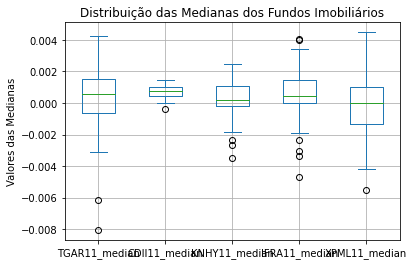

<Figure size 720x432 with 0 Axes>

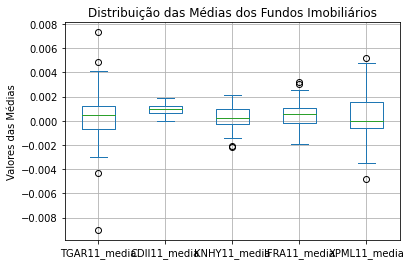

In [0]:
# Importar bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o dataset 'final_flat'
df_final_flat = spark.table("default.final_flat")

# Selecionar apenas as colunas relevantes para a comparação com TGAR11
cols_to_include = [
    "TGAR11_median", "CDII11_median", "KNHY11_median", "IFRA11_median", "XPML11_median",
    "TGAR11_media", "CDII11_media", "KNHY11_media", "IFRA11_media", "XPML11_media"
]

df_filtered = df_final_flat.select(cols_to_include)

# Converter para Pandas DataFrame
df_filtered_pd = df_filtered.toPandas()

# Separar medianas e médias
df_medianas = df_filtered_pd[[
    "TGAR11_median", "CDII11_median", "KNHY11_median", "IFRA11_median", "XPML11_median"
]]
df_medias = df_filtered_pd[[
    "TGAR11_media", "CDII11_media", "KNHY11_media", "IFRA11_media", "XPML11_media"
]]

# Plotar gráficos para medianas
plt.figure(figsize=(10, 6))
df_medianas.plot(kind='box')
plt.title('Distribuição das Medianas dos Fundos Imobiliários')
plt.ylabel('Valores das Medianas')
plt.grid(True)
plt.show()

# Plotar gráficos para médias
plt.figure(figsize=(10, 6))
df_medias.plot(kind='box')
plt.title('Distribuição das Médias dos Fundos Imobiliários')
plt.ylabel('Valores das Médias')
plt.grid(True)
plt.show()


Apesar de se aproximar de uma curva normal, a clara tendência assimétrica à esquerda no caso da TGAR11, principalmente em comparação com os demais fundos, demonstra uma significativa vantagem do fundo frente aos demais

Também os outliers presentes não são tão significativos nesse fundo se comparado a alguns dos demais. 

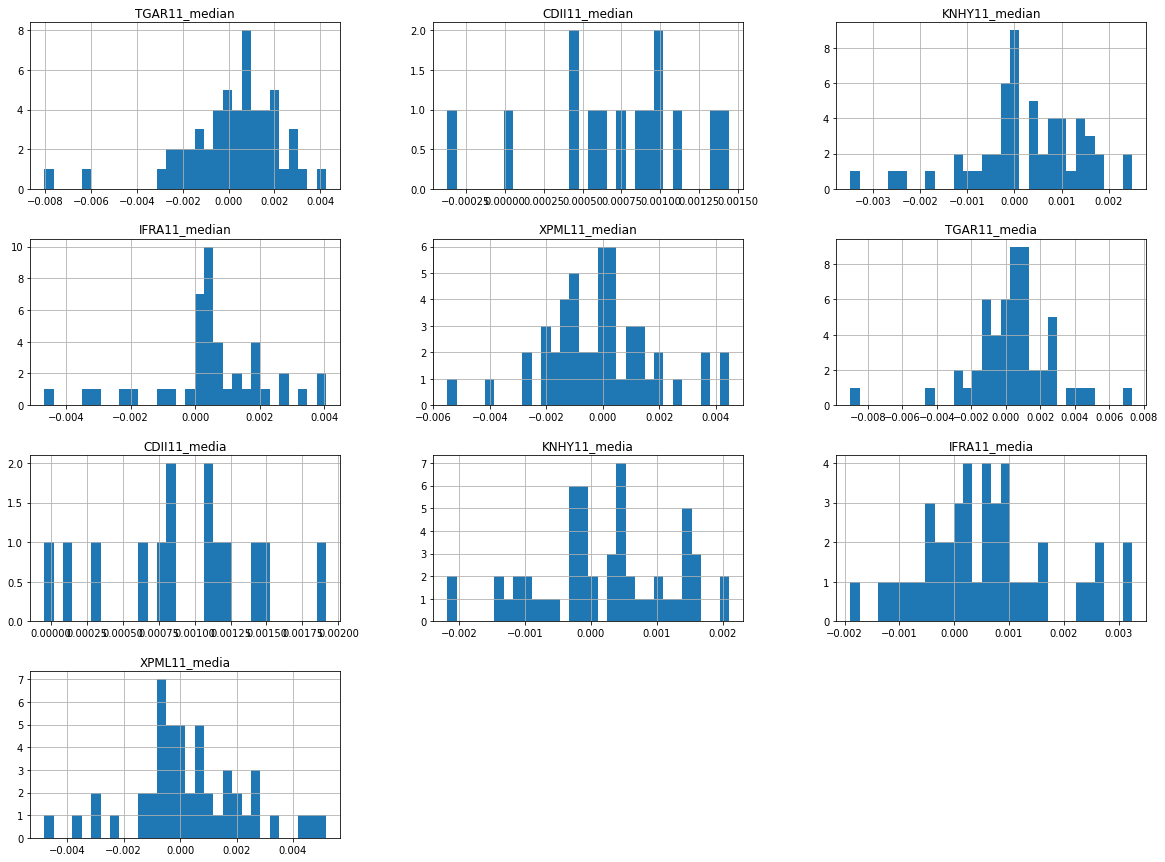

In [0]:
# Importar bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o dataset 'final_flat'
df_final_flat = spark.table("default.final_flat")

# Selecionar apenas as colunas relevantes para a comparação com TGAR11
cols_to_include = [
    "TGAR11_median", "CDII11_median", "KNHY11_median", "IFRA11_median", "XPML11_median",
    "TGAR11_media", "CDII11_media", "KNHY11_media", "IFRA11_media", "XPML11_media"
]

df_filtered = df_final_flat.select(cols_to_include)

# Converter para Pandas DataFrame
df_filtered_pd = df_filtered.toPandas()

# Plotar histogramas para as colunas selecionadas
df_filtered_pd.hist(bins=30, figsize=(20, 15))
plt.show()


A diferença entre os dados exige normalização mara a melhor comparação. Aqui os fundos de interesse são comaprados em série tmeporal e individualmente às variáveis macro analisadas.

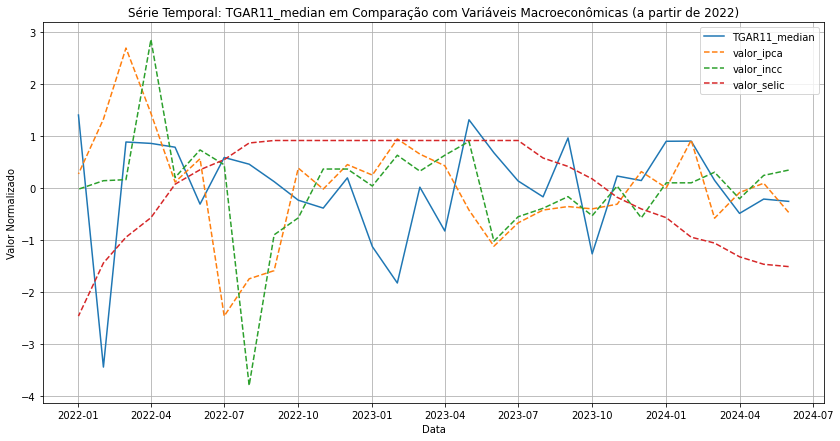

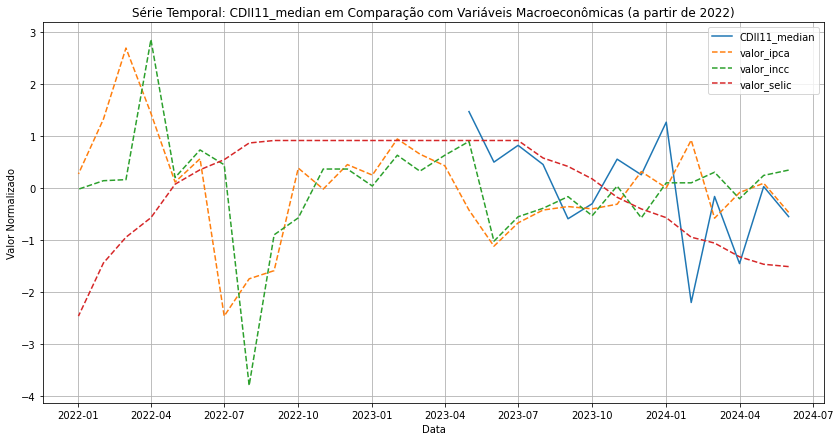

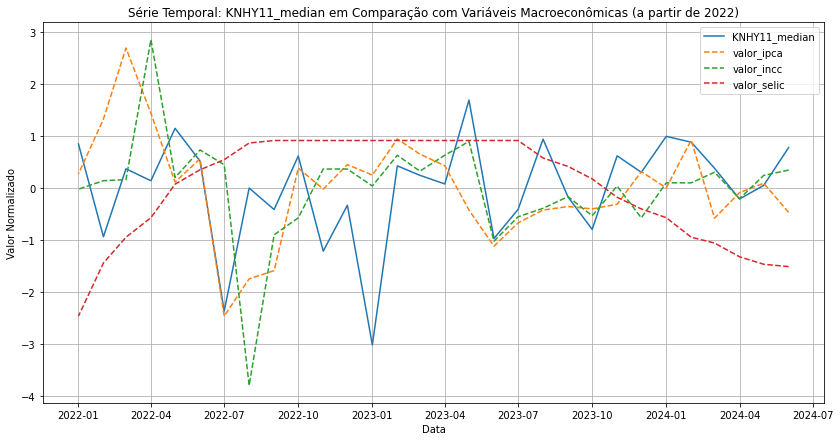

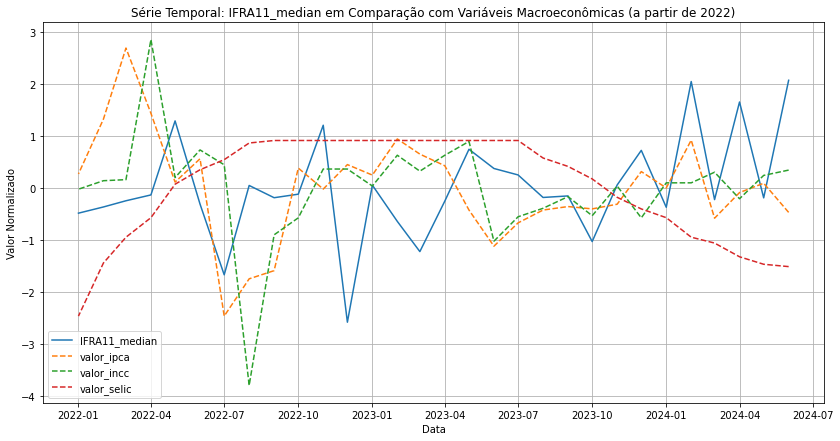

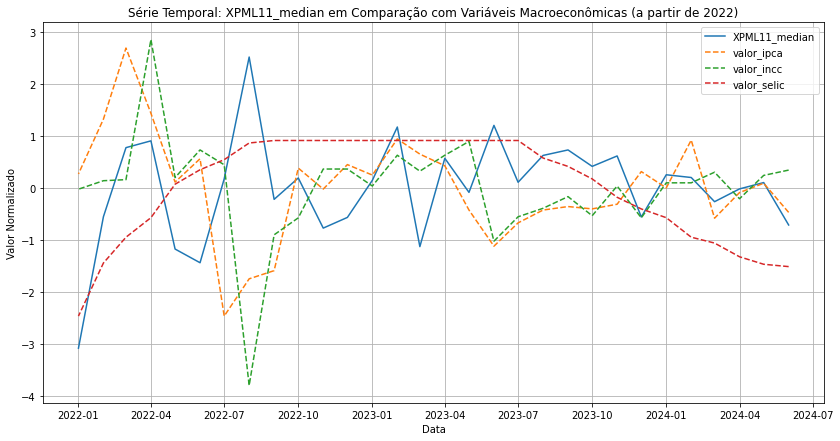

In [0]:
# Importar bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o dataset 'final_flat'
df_final_flat = spark.table("default.final_flat")

# Selecionar apenas as colunas relevantes para a comparação com TGAR11 e variáveis macroeconômicas
cols_to_include = [
    "data", "TGAR11_median", "CDII11_median", "KNHY11_median", "IFRA11_median", "XPML11_median",
    "valor_ipca", "valor_incc", "valor_selic"
]

df_filtered = df_final_flat.select(cols_to_include)

# Converter para Pandas DataFrame
df_filtered_pd = df_filtered.toPandas()

# Converter a coluna de data para o tipo datetime
df_filtered_pd['data'] = pd.to_datetime(df_filtered_pd['data'])

# Filtrar os dados a partir de 2022
df_filtered_pd = df_filtered_pd[df_filtered_pd['data'] >= '2022-01-01']

# Definir a coluna de data como índice
df_filtered_pd.set_index('data', inplace=True)

# Normalizar todas as séries temporais
for column in df_filtered_pd.columns:
    df_filtered_pd[column] = (df_filtered_pd[column] - df_filtered_pd[column].mean()) / df_filtered_pd[column].std()

# Plotar séries temporais normalizadas
funds = ["TGAR11_median", "CDII11_median", "KNHY11_median", "IFRA11_median", "XPML11_median"]
macro_vars = ["valor_ipca", "valor_incc", "valor_selic"]

for fund in funds:
    plt.figure(figsize=(14, 7))
    plt.plot(df_filtered_pd[fund], label=fund)
    for macro in macro_vars:
        plt.plot(df_filtered_pd[macro], label=macro, linestyle='--')
    plt.title(f'Série Temporal: {fund} em Comparação com Variáveis Macroeconômicas (a partir de 2022)')
    plt.xlabel('Data')
    plt.ylabel('Valor Normalizado')
    plt.legend()
    plt.grid(True)
    plt.show()


## Conclusão

A análise rápida das séries levanta sérias dúvidas quanto a algumas afirmações corriqueiras quanto a relações ismplistas entre, por exemplo, a variação da selic e o influxo de capital para os fundos. Da mesma forma, uma análise superficial já fora capaz de demonstrar como uma descritiva é passível de demonstrar distorções significativas nos big numbers demonstrados sobre estes fundos. 

No período analisado, observamos que apesar de um período de queda da selic, para nos mantermos no exemplo mais corriqueiro, não significou variação relevante nos volumes de diversos fundos. Mesmo questões graves como a radical queda do INCC ou mesmo as baixas históricas da Selic não destacma variações de nenhuma forma simétricas entre os diferentes fundos quando analisados com sua linha central antes e depois desses períodos-chave. 